In [1]:
import sisl
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
%matplotlib inline

In this exercise we want to study some properties of a Bismuth monolayer in a buckled hexagonal phase (Bi(111)).

## Exercise
1. Create the geometry in ``sisl`` and save it.
2. Run siesta. A sample input file can be found in the folder of this exercise. Go through the flags to make sure you are familiar with all of them. If not you can always refer to the manual. Make sure that Siesta will save the Hamiltonian. It is required for the next setps. 
```
    siesta Bi2D_BHex.fdf > Bi2D_BHex.out
```
Check the output file. Make sure that the calculation converged and assert that no error have occured.

3. Read the Hamiltonain from the output and calculate the band structure. If you need some help finding the right k-path, you could check [seeK-path](https://www.materialscloud.org/work/tools/seekpath) (SeeK-path is built for 3D systems. Keep in mind our system is 2D. So, not all points might be of interest.)
4. Calculate the spin texture, i.e. the spin moment of the eigenstates, along the same k-path as in 3. You can find out how to do it in the ``sisl`` documentation. 

_Hint the ``sisl.BrillouinZone`` or ``sisl.BandStructure`` object can be used evaulate functions for all k-points._


#### 1 Creating the geometry

The buckled hexagonal crystal structure is similar to the structure of graphene. However, the atoms are not arange in one plane.

|Top view |Side View |
|:--------|:---------|
|<img src="img/Bi2D-BHex-c.png" alt="BHex-c" style="width: 400px;"/>|<img src="img/Bi2D-BHex-a.png" alt="BHex-a" style="width: 400px;"/>|

You can use the in plane lattice constant $a=4.60\mathring{\textrm{A}}$ and a buckling height of $1.62\mathring{\textrm{A}}$. The lattice constant for the orthogonal direction can be large, e.g. $40\mathring{\textrm{A}}$.


In [2]:
a = 4.59845
c = 40.
a1 = a * np.asarray([1., 0., 0.])
a2 = a * np.asarray([-1./2, np.sqrt(3)/2, 0.])
a3 = c * np.asarray([0., 0., 1.])
xyz = [1e-4 * a1, 2./3 * a1 + 1./3 * a2]
xyz[1][2] = 1.62
geom = sisl.Geometry([xyz], sc=sisl.SuperCell([a1,a2,a3]), atom=sisl.Atom('Bi'))
geom.write('STRUC.fdf')

#### 3 Bandstructure

In [5]:
sile = sisl.get_sile('siesta/Bi2D_BHex.fdf')
H = sile.read_hamiltonian(geometry=sile.read_geometry())
Ef = sile.read_fermi_level()

kpath = sisl.BandStructure(H, point=[[1./2, 0., 0.], [0., 0., 0.],
                                     [1./3, 1./3, 0.], [1./2, 0., 0.]],
                           division=301,
                           name=['M', r'$\Gamma$', 'K', r'$\Gamma$'])

In [6]:
lk = kpath.lineark()
xtick, xtick_label = kpath.lineartick()
bands = kpath.eigh(eta=True)
nk, nbands = bands.shape

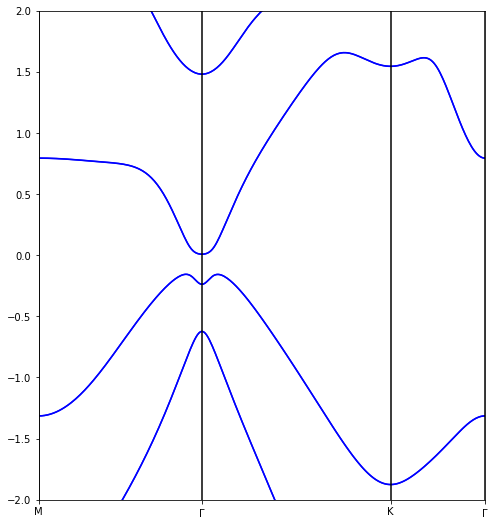

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(8,9))
ymin, ymax = (-2, 2)

for ibnd in range(nbands):
    ax.plot(lk, bands[:, ibnd] - Ef, 'b')

ax.set_xlim(min(lk), max(lk))
ax.set_ylim(ymin, ymax)
ax.xaxis.set_ticks(xtick)
ax.set_xticklabels(xtick_label)
for tick in xtick:
    ax.plot([tick, tick], [ymin, ymax], 'k')
    

#### 4 Spin Texture

In [8]:
spin_moments = kpath.call(H.spin_moment,eta=True)

A convient way to visualize the spin texture is coloring the bands according to the spin moment. 
You can use the template below to plot the spin texture. 

_For reference on how to create multi coloured lines you can see the matplotlib [documentation](https://matplotlib.org/3.1.1/gallery/lines_bars_and_markers/multicolored_line.html)._

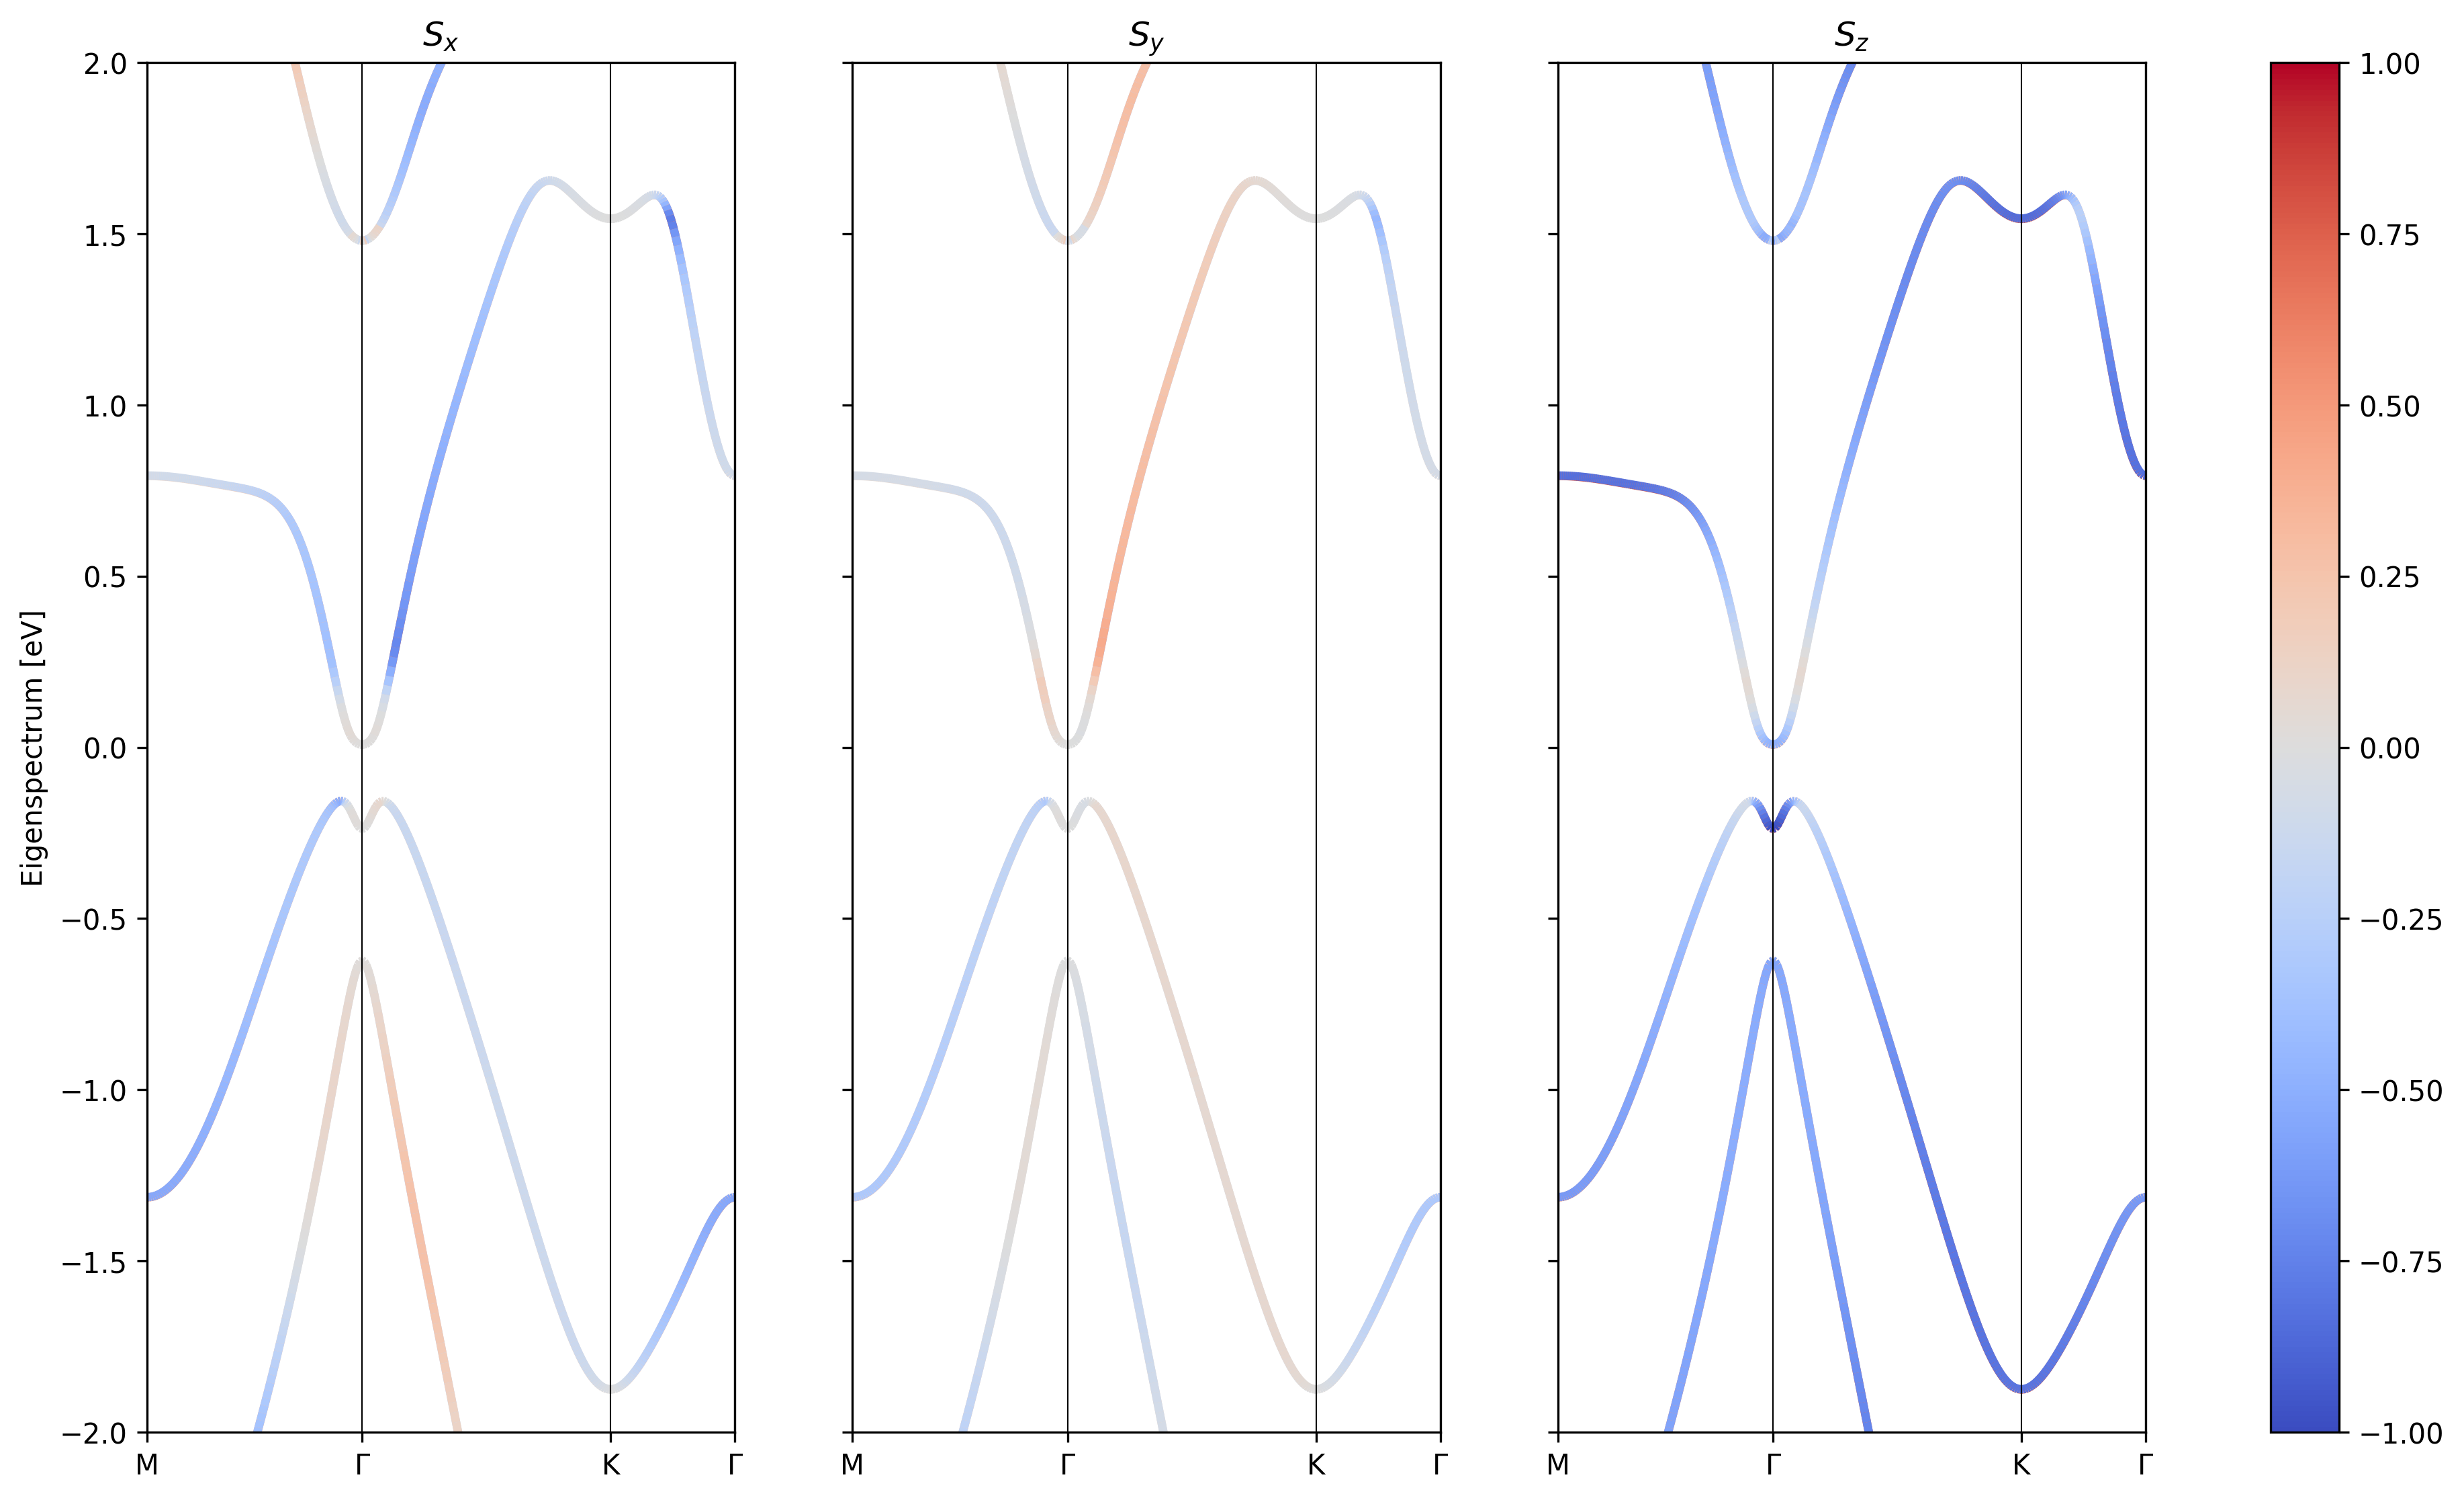

In [9]:
fig, axes = plt.subplots(1, 3, figsize=(16, 9), dpi=300, sharex=True, sharey=True)
norm = plt.Normalize(-1, 1)
ymin, ymax = (-2, 2)

for icomp, component in enumerate(['$S_x$', '$S_y$', '$S_z$']):
    for ibnd in range(bands.shape[1]):
        points = np.array([lk, bands[:, ibnd]-Ef]).T.reshape(-1, 1, 2)
        segments = np.concatenate([points[:-1], points[1:]], axis=1)
        lc = LineCollection(segments, cmap='coolwarm', norm=norm)
        lc.set_array(spin_moments[:, ibnd, icomp])
        lc.set_linewidth(3)
        line = axes[icomp].add_collection(lc)
    axes[icomp].set_title(component)
    
# All subplots share the same axis settings, so we can just them once    
axes[0].set_xlim(min(lk), max(lk))
axes[0].set_ylim(ymin, ymax) 
axes[0].set_ylabel('Eigenspectrum [eV]')
axes[0].xaxis.set_ticks(xtick)
axes[0].set_xticklabels(xtick_label)
    
for axis in axes:
    for tick in xtick:
        axis.plot([tick, tick], [ymin, ymax], 'k', linewidth=0.5)

fig.colorbar(line, ax=axes.ravel().tolist())
plt.show()


What do you notice when you plot every other band, instead of all of them at the same time? Why?